In [10]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import glob
import pickle
from astropy.table import Table
import lmfit
from lmfit.models import VoigtModel
from scipy.interpolate import interp1d
from PyAstronomy import pyasl

import sys
from tqdm import tqdm
sys.path.append('../../wdtools/')
import wdtools
sys.path.append('../../')
from astropy.io import fits
import scipy
import WD_models
plt.style.use('vedant')
from bisect import bisect_left
import lmfit
from scipy.ndimage import gaussian_filter

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458


na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52

ca2k = 3934.777

ch = 4302

plt.rcParams.update({'font.size': 18})
#%matplotlib inline
from matplotlib.colors import LogNorm

In [11]:
lamgrid = np.arange(3500, 9000)
sigma = 1.5 # Angstrom
convolve = False

In [12]:
sys.path.append('../../wdtools/')

import wdtools

sp = wdtools.SpecTools()

def get_spectrum(source_id):
    path = '../spec/'+str(source_id)+'_spec_0.fits'
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        #raise FileNotFoundError('Spectrum file missing...')
        return np.nan, np.nan
    ## RV Correction and Interpolation
    
    return lam, flux

def cont_norm(wl, fl, centre, window, edge):
    c1 = bisect_left(wl, centre - window)
    c2 = bisect_left(wl, centre + window)
    wl, fl = wl[c1:c2], fl[c1:c2]
    
    mask = np.ones(len(wl))
    mask[edge:-edge] = 0
    mask = mask.astype(bool)

    p = np.polynomial.polynomial.polyfit(wl[mask], fl[mask], 1)
    continuum = np.polynomial.polynomial.polyval(wl, p)
    norm_fl = fl / continuum
    return wl, norm_fl

def rv_corr(wl, fl):
    obs_alpha,_,_, _, _ = sp.find_centroid(wl, fl, halpha, make_plot = False, n_fit = 2, 
                            half_window = 50, debug = False, window_step = 5)

    vr = - 1e-3 * speed_light * (obs_alpha - halpha)/halpha

    fl, shift_wl = pyasl.dopplerShift(wl, fl, vr, edgeHandling = 'fillValue', fillValue = 1)
    return wl, fl

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def logg_to_radius(logg):
    g = 10**logg * 0.01 # to SI
    
    R = radius_sun * 10 ** ( - ((np.log10(g / g_sun) + 0.02) / 0.67))
    return R

interpsda = pickle.load(open('interp/interpsda.p', 'rb'))

def get_sda(teff, logg, alpha = 0):
    wl, fl = lamgrid, 10**interpsda((logg, teff, np.log10(lamgrid)))
    
    if convolve:
        fl = scipy.ndimage.gaussian_filter(fl, sigma)
    return wl, fl

def plot_metals(wl, fl, source = '', teff = 6000, logg = 4.5, alpha = 0):
    
    modelwl, modelfl = get_sda(teff, logg, alpha = alpha)
    
    f = plt.figure(figsize = (10, 15))
    gs = f.add_gridspec(4, 2)
    
    ax1 = f.add_subplot(gs[0, :])
    
    
    idx = bisect_left(wl, 5865)
    plt.plot(wl, fl / fl[idx])
    #plt.title(str(obj['source_id'][0]) + ' (%i, %.1f)'%(teff, logg))
    
    ax2 = f.add_subplot(gs[1, 0])
    
    cwl, cfl = cont_norm(wl, fl, ca2k, 20, 5)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, ca2k, 20, 5)
    plt.plot(cwl, cfl)
    #plt.xlim(3925, 3940)
    plt.axvline(ca2k, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.title('Ca II K')
    plt.ylim(0.5, 1.3)
    
    
    ax3 = f.add_subplot(gs[1,1])

    
    cwl, cfl = cont_norm(wl, fl, na2, 75, 15)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, na2, 75, 15)
    plt.plot(cwl, cfl)
#     plt.axvline(na1, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(na2, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.5, 1.3)
    plt.title('Na')
    
    ax4 = f.add_subplot(gs[2,0])
    
    cwl, cfl = cont_norm(wl, fl, ca2, 400, 25)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, ca2, 400, 25)
    plt.plot(cwl, cfl)
    plt.xlim(ca1-25, ca3+25)
#     plt.axvline(ca1, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(ca2, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(ca3, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.5, 1.3)
    plt.title('Ca Triplet')
    
    ax5 = f.add_subplot(gs[2,1])
    
    cwl, cfl = cont_norm(wl, fl, ch, 26, 5)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, ch, 26, 5)
    plt.plot(cwl, cfl)
   # plt.xlim(ca1-20, ca3+20)
    plt.ylim(0.5, 1.3)
    plt.title('CH G-Band')
    
    ax6 = f.add_subplot(gs[3,0])
    
    cwl, cfl = cont_norm(wl, fl, 4320, 30, 5)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, 4320, 30, 5)
    plt.plot(cwl, cfl)
   # plt.xlim(ca1-20, ca3+20)
    plt.ylim(0.5, 1.3)
    plt.title('Carbon')
    
    ax6 = f.add_subplot(gs[3,1])
    
    cwl, cfl = cont_norm(wl, fl, hbeta, 50, 10)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, hbeta, 50, 10)
    plt.plot(cwl, cfl)
    plt.axvline(hbeta, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.1, 1.3)
    plt.title('H-Beta')
    
    
    
    plt.tight_layout()
#     plt.savefig('mp_stars/' + str(source) + '.png', bbox_inches = 'tight')

In [13]:
##### Fit Equivalent Widths

model = lmfit.models.ConstantModel() - lmfit.models.PseudoVoigtModel()
params = model.make_params()
params['c'].set(value = 1, vary = False)
params['amplitude'].set(value = 0.5, min = 0)
params['sigma'].set(value = 1, min = 0)

params

def get_ew(wl, fl, centre, window, edge, plot = False):
    
    wl, fl = cont_norm(wl, fl, centre, window, edge)
    
    params = model.make_params()
    params['c'].set(value = 1, vary = False)
    params['center'].set(value = centre, min = centre - 5, max = centre + 5)
    params['amplitude'].set(value = 1, min = 0)
    params['sigma'].set(value = 2, min = 0, max = 10)
    result = model.fit(fl, params, x = wl)
    profile = model.eval(result.params, x = wl)
    
    if plot:
        plt.plot(wl, fl)
        plt.plot(wl, model.eval(params, x = wl), color = 'k')
        plt.plot(wl, profile)
        plt.show()
    
    dx = np.diff(wl)
    ew = np.sum(((1 - profile))[1:] * dx)
    return ew

In [14]:
teffs = np.linspace(5000, 7000, 25)
ews = [];

for teff in teffs:
    wl,fl = get_sda(teff, 4.5)
    ca2k_ew = get_ew(wl, fl, ca2k, 25, 5, plot = False)
    ews.append(ca2k_ew)

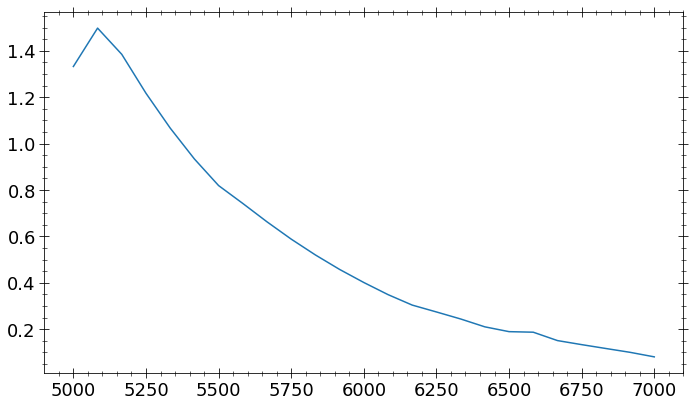

In [15]:
plt.plot(teffs, ews)

## Testing

In [16]:
wl, fl = get_spectrum(149993147175024128)
wl, fl = rv_corr(wl, fl)

def fit_metals(wl, fl):
    
    wl, fl = rv_corr(wl, fl)
    
    ew_ca2k = get_ew(wl, fl, ca2k, 25, 10)
    ew_na = get_ew(wl, fl, (na1 + na2)/2, 25, 10)
    ew_ca1 = get_ew(wl, fl, ca1, 30, 10)
    ew_ca2 = get_ew(wl, fl, ca2, 30, 10)
    ew_ca3 = get_ew(wl, fl, ca3, 30, 10)
    ew_ha = get_ew(wl, fl, halpha, 75, 10)
    ew_ch = get_ew(wl, fl, ch, 20, 7)
    
    return [ew_ca2k, ew_na, ew_ca1, ew_ca2, ew_ca3, ew_ha, ew_ch]

fit_metals(wl, fl)

[2.5701678, 1.4837949, 1.1778467, 2.5375268, 3.3426056, 11.14301, 0.27449304]

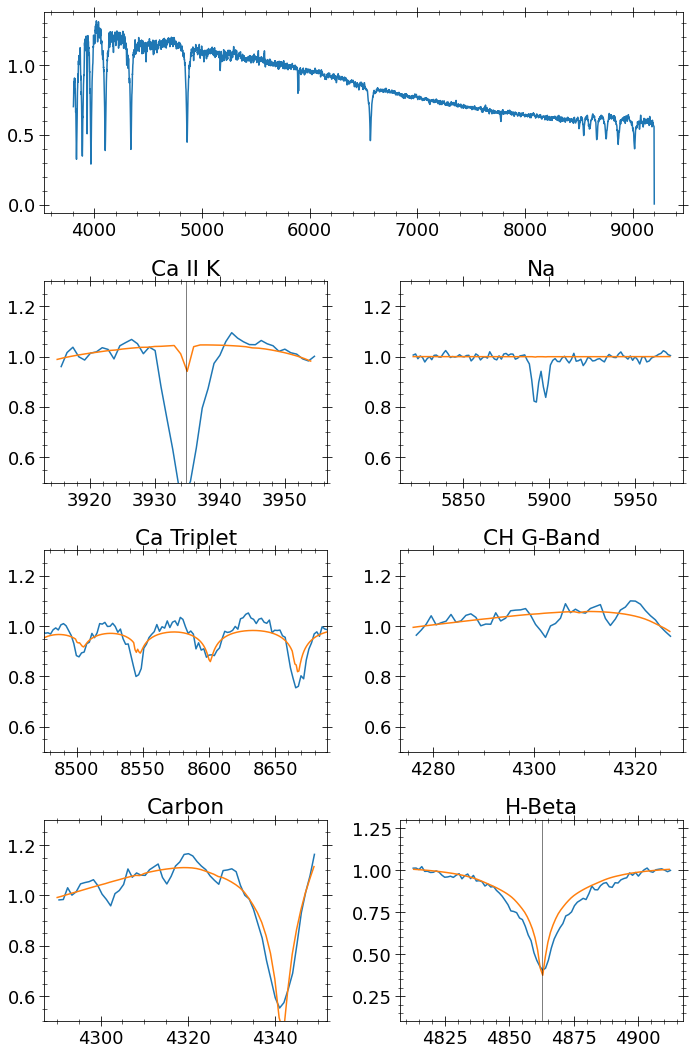

In [17]:
plot_metals(wl, fl, teff = 7500, logg = 4.5, alpha = 0)

# Fit Bad Parallax MPMS for EW

10500

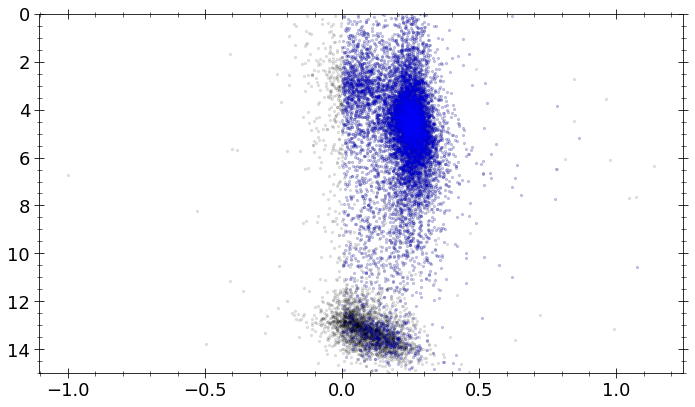

In [18]:
table = Table.read('tables/lr_class.fits')

mpms = (
    (table['p_combined'] > 0.5) * 
    (table['g-r_0'] < 1.2) * 
    (table['g-r_0'] > 0)
)

plt.scatter(table['g-r_0'], table['g_abs'], color = 'k', s = 5, alpha = 0.1)
plt.scatter(table['g-r_0'][mpms], table['g_abs'][mpms], color = 'b', s = 5, alpha = 0.1)

plt.gca().invert_yaxis()
plt.ylim(15, 0)

table = table[mpms]
len(table)

In [19]:
table['ca2k'] = np.repeat(np.nan, len(table))
table['na'] = np.repeat(np.nan, len(table))
table['ca1'] = np.repeat(np.nan, len(table))
table['ca2'] = np.repeat(np.nan, len(table))
table['ca3'] = np.repeat(np.nan, len(table))
table['alpha'] = np.repeat(np.nan, len(table))
table['ch'] = np.repeat(np.nan, len(table))

In [20]:
makeplot = False

for obj in tqdm(table):
    
    wl, fl = get_spectrum(obj['source_id'])
        
    if wl is np.nan:
        print('skip')
        continue
    if fl[0] == 0 or len(wl) == 0:
        print('skip')
        continue;
        
    if makeplot:
        
        print(obj['source_id'])
        print(obj['ra'], obj['dec'])
        print(obj['parallax_over_error'])
        print(obj['ty'])
        print(obj['pmf'])
    
    try:
        metals = fit_metals(wl, fl)
    except KeyboardInterrupt:
        raise
    except:
        #raise
        print('fit failed...')
        continue
    
    obj['ca2k'] = metals[0]
    obj['na'] = metals[1]
    obj['ca1'] = metals[2]
    obj['ca2'] = metals[3]
    obj['ca3'] = metals[4]
    obj['alpha'] = metals[5]
    obj['ch'] = metals[6]

  2%|▏         | 235/10500 [01:00<33:37,  5.09it/s]

fit failed...


  5%|▍         | 496/10500 [02:09<41:34,  4.01it/s]  

fit failed...


  8%|▊         | 817/10500 [03:38<38:45,  4.16it/s]

fit failed...


 22%|██▏       | 2354/10500 [10:31<33:45,  4.02it/s]  

fit failed...


 23%|██▎       | 2383/10500 [10:38<39:11,  3.45it/s]

fit failed...


 24%|██▎       | 2486/10500 [11:06<30:22,  4.40it/s]

fit failed...


 27%|██▋       | 2859/10500 [12:53<36:10,  3.52it/s]  

fit failed...


 28%|██▊       | 2914/10500 [13:10<45:12,  2.80it/s]  

fit failed...


 33%|███▎      | 3482/10500 [15:53<31:31,  3.71it/s]

fit failed...


 33%|███▎      | 3486/10500 [15:55<32:18,  3.62it/s]

fit failed...


 35%|███▍      | 3664/10500 [16:51<31:46,  3.59it/s]  

fit failed...


 39%|███▉      | 4082/10500 [18:53<35:44,  2.99it/s]  

fit failed...


 42%|████▏     | 4460/10500 [20:44<25:45,  3.91it/s]

fit failed...


 45%|████▍     | 4690/10500 [21:54<29:01,  3.34it/s]  

fit failed...


 47%|████▋     | 4886/10500 [22:52<24:17,  3.85it/s]

fit failed...


 48%|████▊     | 5007/10500 [23:33<33:37,  2.72it/s]/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

caution, none of the iterated fits were succesful
fit failed...


 48%|████▊     | 5042/10500 [23:45<24:22,  3.73it/s]

fit failed...


 49%|████▊     | 5118/10500 [24:10<25:29,  3.52it/s]

fit failed...


 50%|████▉     | 5206/10500 [24:39<24:09,  3.65it/s]

fit failed...


 53%|█████▎    | 5566/10500 [26:37<24:55,  3.30it/s]

fit failed...


 58%|█████▊    | 6086/10500 [29:47<23:50,  3.09it/s]  

fit failed...


 63%|██████▎   | 6578/10500 [32:39<22:07,  2.95it/s]

fit failed...


 66%|██████▌   | 6903/10500 [34:45<16:49,  3.56it/s]  

fit failed...


 66%|██████▋   | 6974/10500 [35:14<21:49,  2.69it/s]

fit failed...


 68%|██████▊   | 7147/10500 [36:18<20:11,  2.77it/s]

fit failed...


 68%|██████▊   | 7155/10500 [36:20<15:07,  3.69it/s]

fit failed...


 70%|███████   | 7381/10500 [37:43<17:43,  2.93it/s]

fit failed...


 73%|███████▎  | 7670/10500 [39:07<15:15,  3.09it/s]

fit failed...


 84%|████████▎ | 8785/10500 [44:35<06:10,  4.62it/s]

fit failed...


100%|██████████| 10500/10500 [52:51<00:00,  3.31it/s]


## Write Table

In [22]:
table.write('tables/ew_table.fits', overwrite = True)